In [9]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16}) 

import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
import phenom

import lal
import lalsimulation as lalsim

import lalutils

In [10]:
import greedyrb
# import gprfit
import fitslr

In [11]:
import surrogate

In [15]:
import george

# data acquisition

We need a function that we can call to
generate data in a uniform way.

We will use this to generate the data for:
 - the seed basis
 - additional training sets and
 - validation sets

In [12]:
def gen_1d_massratio_data(q_array, M, deltaT=1/1024., f_min=10,
                         approximant=lalsim.SEOBNRv4P, inclination=0,
                          t_min=-5000, t_max=50, npts=5000
                         ):

    new_times = np.linspace(t_min, t_max, npts)
    
    data = []
    coords = []
    
    for q in q_array:
        m1, m2 = phenom.m1_m2_M_q(M, q)
        pp = dict(m1=m1, m2=m2, deltaT=deltaT,
                  f_min=f_min,
                  inclination=inclination,
                  approximant=approximant
                 )
        p = lalutils.gen_td_wf_params(**pp)
        t, amp, phase = lalutils.gen_td_wf(p, t_min=t_min, t_max=t_max)
              
        iamp = IUS(t, amp)
        iphase = IUS(t, phase)
        
        # interpolate around peak
#         max_amp_idx = amp.argmax()
#         tpeak = t[max_amp_idx]
#         t_fine = np.linspace(tpeak-10, tpeak+10,1000)
#         amp_fine = iamp(t_fine)
#         tpeak = t_fine[amp_fine.argmax()]
        
        
#         iamp = IUS(t-tpeak, amp)
#         iphase = IUS(t-tpeak, phase)
        amp = iamp(new_times)
        phase = iphase(new_times)
        

        
        d = {"t":new_times, "amp":amp, "phase":phase}
        
        data.append(d)
        coords.append([q])
    
    n_t_points = len(new_times)
    n_waveforms = len(data)
    ts_amp = np.zeros(shape=(n_waveforms, n_t_points))
    ts_phase = np.zeros(shape=(n_waveforms, n_t_points))
    
    
    
    for i in range(n_waveforms):
        ts_amp[i] = data[i]['amp'] / phenom.eta_from_q(coords[i][0]) / 1e5
        ts_phase[i] = data[i]['phase'] - data[i]['phase'][0]
        
    return new_times, ts_amp, ts_phase, np.array(coords)

In [234]:
seed_x, seed_ts_amp, seed_ts_phase, seed_ts_coords = gen_1d_massratio_data(np.linspace(1,10,3), 100)

In [235]:
seed_ts_amp.shape

(3, 5000)

In [236]:
seed_ts_coords

array([[ 1. ],
       [ 5.5],
       [10. ]])

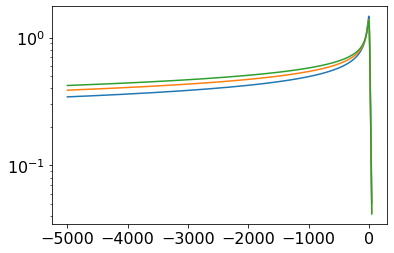

In [237]:
plt.figure()
for i in range(len(seed_ts_amp)):
#     plt.plot(seed_x, seed_ts_amp[i] / phenom.eta_from_q(seed_ts_coords[i]))
    plt.plot(seed_x, seed_ts_amp[i])
plt.yscale('log')

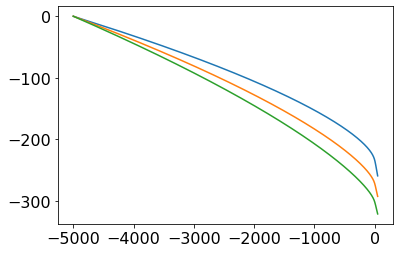

In [238]:
plt.figure()
for i in range(len(seed_ts_amp)):
    plt.plot(seed_x, seed_ts_phase[i])

# run

In [240]:
# Make integration rule

int_range = [seed_x[0], seed_x[-1]]
int_num = len(seed_x)

integration = greedyrb.Riemann(int_range, num=int_num)
x = integration.nodes  # Define x for convenience

In [241]:
sur = surrogate.Surrogate1D(integration)

In [242]:
sur.build_seed_basis(ts=seed_ts_amp, ts_coords=seed_ts_coords)

building seed basis


In [243]:
sur.grb.greedy_points

array([[ 1. ],
       [ 5.5],
       [10. ]])

In [244]:
# check seed basis and add points
_, ts_amp, _, ts_coords = gen_1d_massratio_data(np.random.uniform(1,10,100), 100)

In [245]:
sur.run_greedy_sweep(ts_amp, ts_coords, verbose=True, greedy_tol=1e-3)

tolerance reached. exiting


In [246]:
# build eim
# eim needs to be built from training_set at the greedy points
_, ts, _, _ = gen_1d_massratio_data(sur.grb.greedy_points.ravel(), 100)

In [247]:
sur.build_eim(ts)

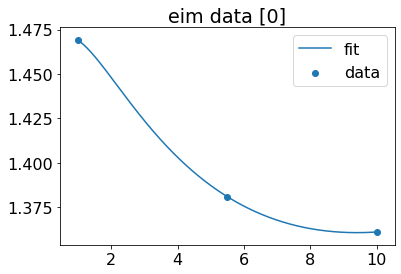

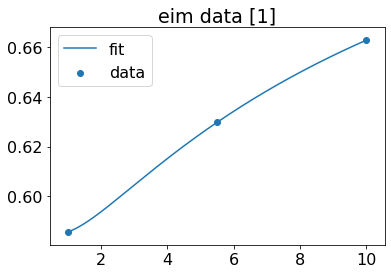

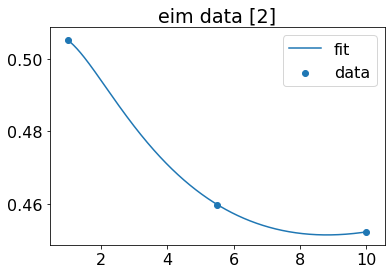

In [248]:

# fit_eim
solver=george.HODLRSolver
# solver=george.BasicSolver
# sur.fit_eim(method='gpr', solver=solver, jitter=1e-2)
sur.fit_eim(method='lr', maxdegs=[4], solver=george.HODLRSolver, verbose=True, jitter=1e-4)
# sur.fit_eim(method='gpr', maxdegs=[4], solver=george.HODLRSolver, verbose=True, jitter=1e-4)

In [249]:
sur.grb.nbasis

3

In [250]:
_, vts, _, vts_coords = gen_1d_massratio_data(np.random.uniform(1,10,100), 100)

In [251]:
model_errors, worst_case, worst_error_index = sur.validate_surrogate(vts, vts_coords)
print(f"worst case = {worst_case}")

worst case = [2.41325313]


In [252]:
%%timeit
_ = gen_1d_massratio_data([5.4], 100)

454 ms ± 6.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [253]:
%%timeit
sur.predict(worst_case)

165 µs ± 5.03 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [254]:
452e-3/156e-6

2897.4358974358975

In [255]:
470e-3/156e-6

3012.8205128205127

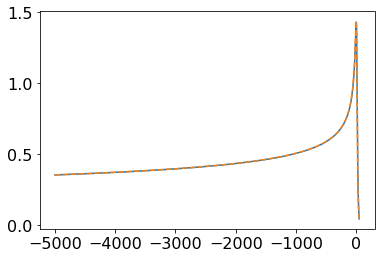

In [256]:
plt.figure()
plt.plot(seed_x, vts[worst_error_index])
plt.plot(seed_x, sur.predict(worst_case), ls='--')

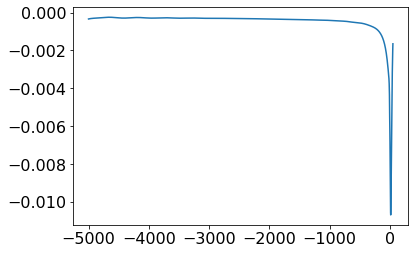

In [257]:
plt.figure()
plt.plot(seed_x, vts[worst_error_index] - sur.predict(worst_case))

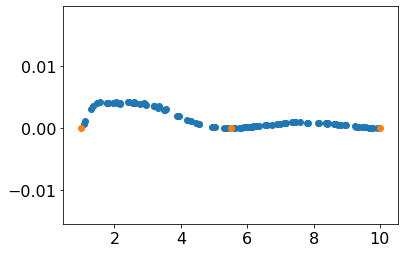

In [258]:
plt.figure()
plt.scatter(vts_coords, model_errors)
plt.scatter(sur.grb.greedy_points, np.zeros(len(sur.grb.greedy_points)))
plt.show()
plt.close()

In [259]:
vts_worst = vts[worst_error_index]
vts_coords_worst = vts_coords[worst_error_index]

In [260]:
vts_coords_worst

array([2.41325313])

In [261]:
vts_worst.shape

(5000,)

In [262]:
# vts_worst.reshape(1,-1)

In [263]:
# add the worst case to the basis and re-fit
sur.run_greedy_sweep(vts_worst.reshape(1,-1), vts_coords_worst.reshape(1, -1), greedy_tol=1e-7)

step = 0, error = 0.00048566949424664203


In [264]:
sur.grb.nbasis

4

In [265]:
# build eim
# eim needs to be built from training_set at the greedy points
_, ts, _, _ = gen_1d_massratio_data(sur.grb.greedy_points.ravel(), 100)

In [266]:
sur.build_eim(ts)

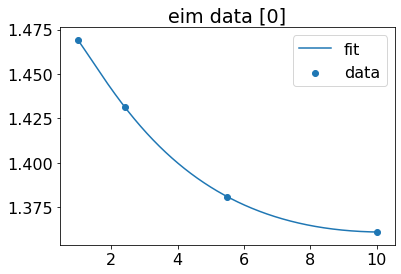

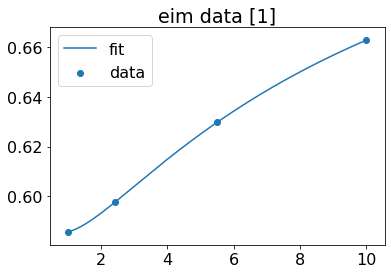

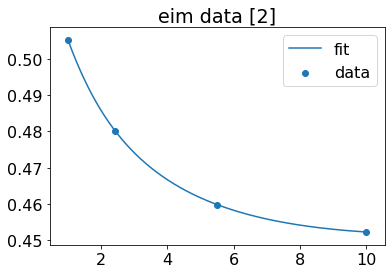

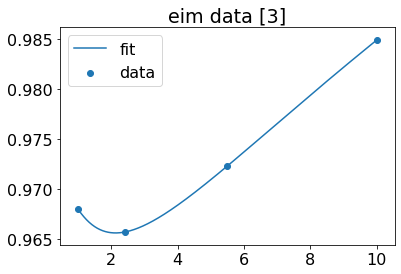

In [267]:
# fit_eim
solver=george.HODLRSolver
# solver=george.BasicSolver
# sur.fit_eim(method='gpr', solver=solver, jitter=1e-2)
sur.fit_eim(method='lr', maxdegs=[4], solver=george.HODLRSolver, verbose=True, jitter=1e-2)
# sur.fit_eim(method='gpr', maxdegs=[4], solver=george.HODLRSolver, verbose=True, jitter=1e-2)

In [268]:
model_errors, worst_case, worst_error_index = sur.validate_surrogate(vts, vts_coords)
print(f"worst case = {worst_case}")

worst case = [1.36127396]


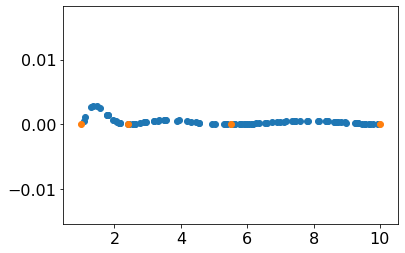

In [269]:
plt.figure()
plt.scatter(vts_coords, model_errors)
plt.scatter(sur.grb.greedy_points, np.zeros(len(sur.grb.greedy_points)))
plt.show()
plt.close()

# condensed code

In [17]:
def build_surrogate(amp_or_phase):
    seed_x, seed_ts_amp, seed_ts_phase, seed_ts_coords = gen_1d_massratio_data(np.linspace(1,10,3), 100)
    # Make integration rule

    int_range = [seed_x[0], seed_x[-1]]
    int_num = len(seed_x)

    integration = greedyrb.Riemann(int_range, num=int_num)
    x = integration.nodes  # Define x for convenience
    
    sur = surrogate.Surrogate1D(integration)
    
    if amp_or_phase == "amp":
        seed_ts = seed_ts_amp
    elif amp_or_phase == "phase":
        seed_ts = seed_ts_phase
        
        
    sur.build_seed_basis(ts=seed_ts, ts_coords=seed_ts_coords)
    
    # check seed basis and add points
    _, ts_amp, ts_phase, ts_coords = gen_1d_massratio_data(np.random.uniform(1,10,100), 100)
    
    if amp_or_phase == "amp":
        ts = ts_amp
    elif amp_or_phase == "phase":
        ts = ts_phase    
    sur.run_greedy_sweep(ts, ts_coords, verbose=True, greedy_tol=1e-3)
    
    # build eim
    # eim needs to be built from training_set at the greedy points
    _, ts_amp, ts_phase, _ = gen_1d_massratio_data(sur.grb.greedy_points.ravel(), 100)
    if amp_or_phase == "amp":
        ts = ts_amp
    elif amp_or_phase == "phase":
        ts = ts_phase 
    sur.build_eim(ts)
    
    
    # fit_eim
    solver=george.HODLRSolver
    # solver=george.BasicSolver
    # sur.fit_eim(method='gpr', solver=solver, jitter=1e-2)
    sur.fit_eim(method='lr', maxdegs=[4], solver=george.HODLRSolver, verbose=False, jitter=1e-4)
    # sur.fit_eim(method='gpr', maxdegs=[4], solver=george.HODLRSolver, verbose=True, jitter=1e-4)
    
    print(f"total number of greedy points = {sur.grb.nbasis}")
    
    
    _, vts_amp, vts_phase, vts_coords = gen_1d_massratio_data(np.random.uniform(1,10,100), 100)
    if amp_or_phase == "amp":
        vts = vts_amp
    elif amp_or_phase == "phase":
        vts = vts_phase 
        
    model_errors, worst_case, worst_error_index = sur.validate_surrogate(vts, vts_coords)
    print(f"worst case = {worst_case}")
    
    plt.figure()
    plt.scatter(vts_coords, model_errors)
    plt.scatter(sur.grb.greedy_points, np.zeros(len(sur.grb.greedy_points)))
    plt.show()
    plt.close()

    vts_worst = vts[worst_error_index]
    vts_coords_worst = vts_coords[worst_error_index]
    
    return x, sur

building seed basis
tolerance reached. exiting
total number of greedy points = 3
worst case = [2.67713889]


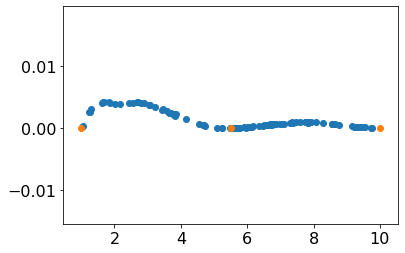

In [18]:
amp_x, amp_sur = build_surrogate(amp_or_phase='amp')

building seed basis
step = 0, error = 21.24320947117152
step = 1, error = 0.20393967405804617
step = 2, error = 0.00603544799988247
step = 3, error = 0.004369448147953619
tolerance reached. exiting
total number of greedy points = 7
worst case = [1.03318656]


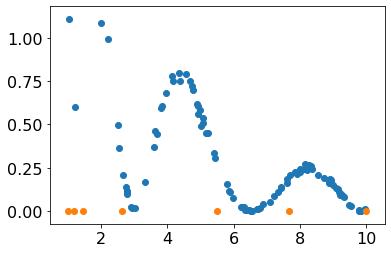

In [19]:
phase_x, phase_sur = build_surrogate(amp_or_phase='phase')

In [20]:
phase_sur.predict([[1]])

array([ 0.00000000e+00, -3.47616899e-02, -6.94813105e-02, ...,
       -2.58191632e+02, -2.58750417e+02, -2.59309233e+02])

In [32]:
def wave_sur(q, amp_sur=amp_sur, phase_sur=phase_sur):
    
    amp = amp_sur.predict([[q]])
    phase = phase_sur.predict([[q]])
    h = amp * np.exp(-1.j * phase)
    
    return np.real(h), np.imag(h), amp, phase

In [62]:
vs_x, vs_amp, vs_phase, vt_coords = gen_1d_massratio_data([1], 100)
vs_h = vs_amp[0] * np.exp(-1.j * vs_phase[0])
vs_hp = np.real(vs_h)
vs_hc = np.imag(vs_h)

In [68]:
sur_hp, sur_hc, samp, sphase = wave_sur(1)

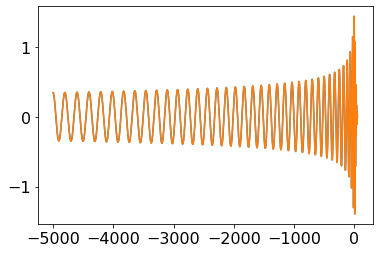

In [69]:
plt.figure()
plt.plot(x, vs_hp)
plt.plot(x, sur_hp)

In [70]:
def match(h1, h2, times):
        
    dt = times[1] - times[0]
    n = len(times)
    df = 1.0/(n*dt)
    norm = 4. * df
    
    h1_fft = np.fft.fft(h1)
    h2_fft = np.fft.fft(h2)
    
    h1h1_sq = np.vdot(h1_fft, h1_fft) * norm
    h2h2_sq = np.vdot(h2_fft, h2_fft) * norm
    
    h1h1 = dt * np.sqrt(h1h1_sq)
    h2h2 = dt * np.sqrt(h2h2_sq)
    

    ifft = np.fft.ifft(np.conj(h1_fft) * h2_fft)
    
    return ifft / h1h1 / h2h2 * 4 * dt

0.9999708712509675

In [76]:
qs = np.linspace(1,10,100)
matches = np.zeros(len(qs))
for i, q in enumerate(qs):
    print(f"working q = {q}")
    vs_x, vs_amp, vs_phase, vt_coords = gen_1d_massratio_data([q], 100)
    vs_h = vs_amp[0] * np.exp(-1.j * vs_phase[0])
    vs_hp = np.real(vs_h)
    vs_hc = np.imag(vs_h)
    
    sur_hp, sur_hc, samp, sphase = wave_sur(q)
    
    maxmatch = np.max(np.abs(match(vs_hp, sur_hp, x)))
    
    matches[i] = maxmatch
    
#     plt.figure()
#     plt.plot(x, vs_hp)
#     plt.plot(x, sur_hp)
#     plt.show()
#     plt.close()

working q = 1.0
working q = 1.0909090909090908
working q = 1.1818181818181819
working q = 1.2727272727272727
working q = 1.3636363636363638
working q = 1.4545454545454546
working q = 1.5454545454545454
working q = 1.6363636363636362
working q = 1.7272727272727273
working q = 1.8181818181818183
working q = 1.9090909090909092
working q = 2.0
working q = 2.090909090909091
working q = 2.1818181818181817
working q = 2.2727272727272725
working q = 2.3636363636363638
working q = 2.4545454545454546
working q = 2.5454545454545454
working q = 2.6363636363636367
working q = 2.7272727272727275
working q = 2.8181818181818183
working q = 2.909090909090909
working q = 3.0
working q = 3.090909090909091
working q = 3.1818181818181817
working q = 3.272727272727273
working q = 3.3636363636363638
working q = 3.4545454545454546
working q = 3.5454545454545454
working q = 3.6363636363636362
working q = 3.7272727272727275
working q = 3.8181818181818183
working q = 3.909090909090909
working q = 4.0
working q =

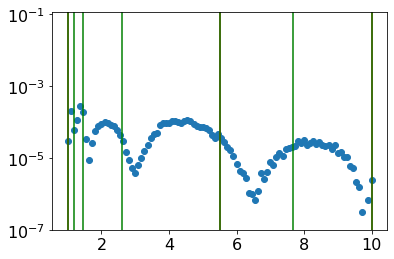

In [85]:
plt.figure()
plt.scatter(qs, 1-matches)
plt.yscale('log')
plt.ylim(1e-7)
for gp in amp_sur.grb.greedy_points:
    plt.axvline(gp, c='r')
for gp in phase_sur.grb.greedy_points:
    plt.axvline(gp, c='g')